<a href="https://colab.research.google.com/github/dokeyuka/deep-learning-practice/blob/main/cis6930_week3_convolutional_neural_networks_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS6930 Week 3: Convolutional Neural Networks

---

Preparation: Go to `Runtime > Change runtime type` and choose `GPU` for the hardware accelerator.



In [2]:
gpu_info = !nvidia-smi -L
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
  print("Not connected to a GPU")
else:
  print(gpu_info)

GPU 0: Tesla T4 (UUID: GPU-c957f735-5bde-bc55-b6e6-592ad5046ff8)


## Preparation

In [3]:
import copy
import random
from time import time
from typing import Any, Dict

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, TensorDataset, DataLoader

### Loading the MNIST dataset

In [4]:
import torchvision

train_dataset = torchvision.datasets.MNIST("./data", train=True, download=True,
                                            transform=torchvision.transforms.Compose(
                                                [torchvision.transforms.ToTensor(),
                                                 # For standardization: 0.1307 (mean), 0.3081 (var)
                                                 torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000],
                                                             generator=torch.Generator().manual_seed(5))
test_dataset = torchvision.datasets.MNIST("/data", train=False, download=True,
                                           transform=torchvision.transforms.Compose(
                                               [torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



In [9]:
print(train_dataset[0][0].squeeze(0).shape)
print(train_dataset[0][0].shape)
#.squeeze(axis = 0)
#次元のサイズが1の場合その次元が圧縮される

torch.Size([28, 28])
torch.Size([1, 28, 28])


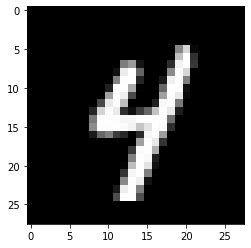

In [5]:
from matplotlib import pyplot as plt

plt.imshow(train_dataset[0][0].squeeze(0), cmap="gray", interpolation="none")

## Implementing Convolutional Filter & Pooling from Scratch

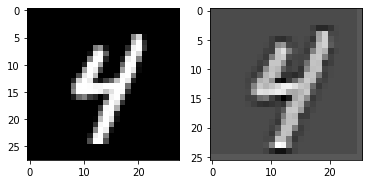

In [10]:
# Convolutional filter
filter = np.array([[-1, -1, -1],
                   [1, 8, 1],
                   [-1, -1, -1]])

data = train_dataset[0][0].squeeze(0).detach().cpu().numpy()
stride = 1

# 
feature_map = np.zeros((
    int(((data.shape[0] - filter.shape[0]) / stride) + 1),
    int(((data.shape[1] - filter.shape[1]) / stride) + 1)))

for i in range(0, data.shape[0] - filter.shape[0], stride):
    for j in range(0, data.shape[1] - filter.shape[1], stride):
        val = 0.
        for k in range(filter.shape[0]):
            for l in range(filter.shape[1]):
              # Aggregating weighted values
              val += data[i + k][j + l] * filter[k][l]
        feature_map[i][j] = val

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(data, cmap="gray", interpolation="none")
ax2 = plt.subplot(1, 2, 2)
ax2.imshow(feature_map, cmap="gray", interpolation="none")
plt.show()

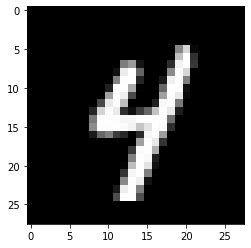

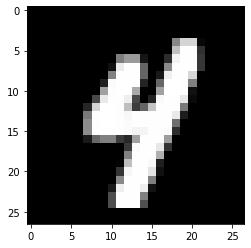

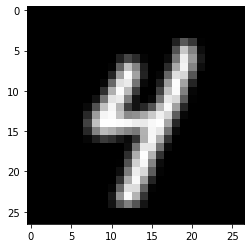

In [11]:
def pooling(data, pool_size, pooling_func):
    """
    Feature map shape: ((W - F) / S) + 1
    """
    pool_size_x = pool_size_y = sride = pool_size

    feature_map = np.zeros((
        int(((data.shape[0] - pool_size_x) / stride) + 1),
        int(((data.shape[1] - pool_size_y) / stride) + 1)))

    for i in range(0, data.shape[0] - pool_size_x + 1, stride):
        for j in range(0, data.shape[1] - pool_size_y + 1, stride):
            if pooling_func == "max":#max_pooling
                feature_map[int(i/stride)][int(j/stride)] = data[i:i+pool_size_x, j:j+pool_size_y].max()
            elif pooling_func == "mean":#min_pooling
                feature_map[int(i/stride)][int(j/stride)] = data[i:i+pool_size_x, j:j+pool_size_y].mean()
            else:
                raise ValueError("Invalid pooling name")
    return feature_map

# Pooling
data = train_dataset[0][0].squeeze(0).detach().cpu().numpy()

plt.imshow(data, cmap="gray", interpolation="none")
plt.show()
plt.imshow(pooling(data, pool_size=2, pooling_func="max"), cmap="gray", interpolation="none")
plt.show()
plt.imshow(pooling(data, pool_size=2, pooling_func="mean"), cmap="gray", interpolation="none")
plt.show()

## Getting Familiar with Convolution & Pooling (Hands-on Session)


### Playing & Customizing Conv Filter

torch.Size([8, 1, 28, 28])
torch.Size([1, 1, 3, 3])
Parameter containing:
tensor([[[[ 0.1700, -0.2622,  0.0189],
          [-0.2537,  0.2694,  0.0695],
          [-0.2313,  0.0143, -0.1668]]]], requires_grad=True)
Parameter containing:
tensor([[[[-1., -1., -1.],
          [ 8.,  8.,  8.],
          [-1., -1., -1.]]]], requires_grad=True)


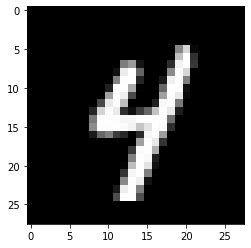

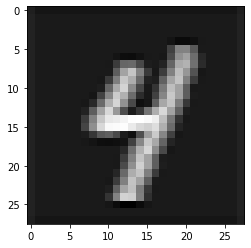

In [12]:
# Sample a batch
batch_size = 8
dl_train = DataLoader(train_dataset, batch_size=batch_size)
batch = next(iter(dl_train))
X, y = batch

print(X.shape) # (8, 1, 28, 28)

# Set custom weight for analysis
custom_filter1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3,
                           stride=1, padding=1)
print(custom_filter1.weight.shape)
print(custom_filter1.weight)

# Custom convolutional filter
custom_filter1.weight = torch.nn.Parameter(
    torch.FloatTensor([[
                        [[-1, -1, -1],
                         [8, 8, 8],
                         [-1, -1, -1]]]]))
print(custom_filter1.weight)

# Original image
plt.imshow(X[0].squeeze(0).detach().cpu().numpy(), cmap="gray", interpolation="none")
plt.show()

# Feature map
custom_fm1 = custom_filter1(X)  # (8, 1, 28, 28)
plt.imshow(custom_fm1[0].squeeze(0).detach().cpu().numpy(), cmap="gray", interpolation="none")
plt.show()

### Layer 1: Conv Filter

torch.Size([1, 28, 28])
torch.Size([8, 1, 28, 28])


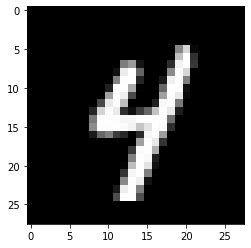

torch.Size([8, 1, 28, 28])


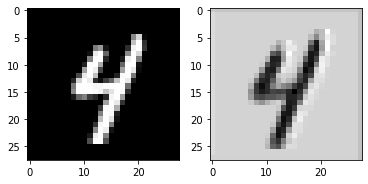

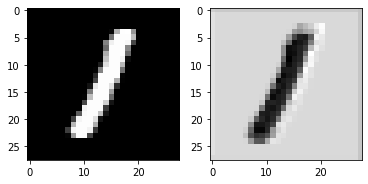

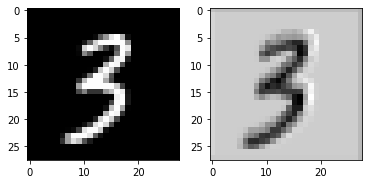

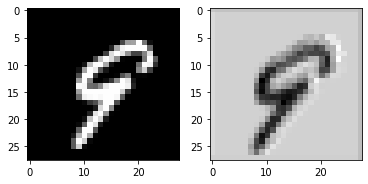

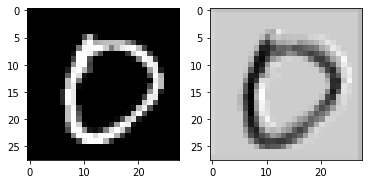

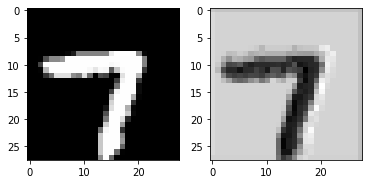

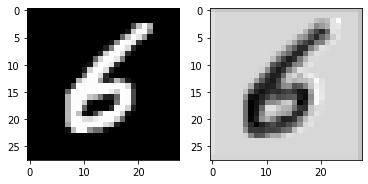

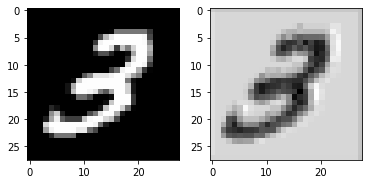

In [13]:
filter1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3,
                    stride=1, padding=1)

print(train_dataset[0][0].shape) # (n_channels, height, weight)

dl_train = DataLoader(train_dataset, batch_size=batch_size)
batch = next(iter(dl_train))
X, y = batch
print(X.shape)  # (batch_size, n_channels, height, weight) = (8, 1, 28, 28)
plt.imshow(X[0].squeeze(0), cmap="gray", interpolation="none")
plt.show()

fm1 = filter1(X)  # (8, 1, 28, 28)
print(fm1.shape)

for n in range(8):
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(X[n, 0, :, :].detach().cpu().numpy(),  cmap="gray", interpolation="none")
    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(fm1[n, 0, :, :].detach().cpu().numpy(),  cmap="gray", interpolation="none")
    plt.show()

### Layer 2: Conv Filter

torch.Size([8, 5, 26, 26])


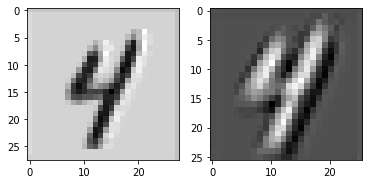

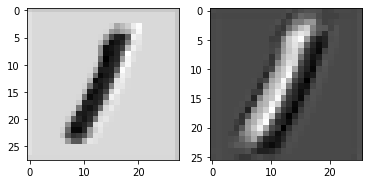

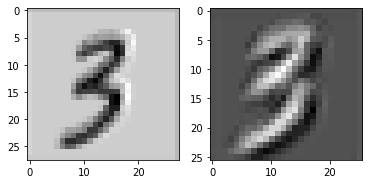

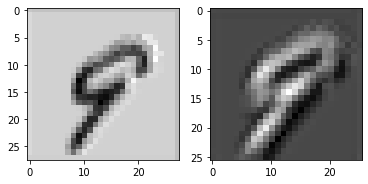

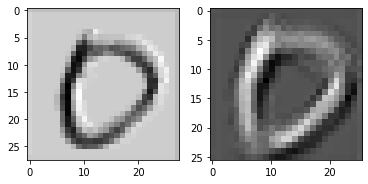

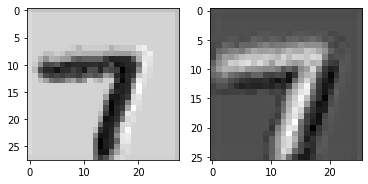

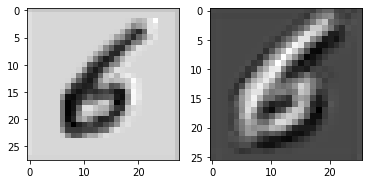

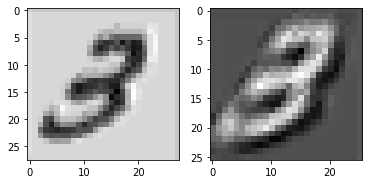

In [14]:
filter2 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5,
                    stride=1, padding=1)
fm2 = filter2(fm1)  # (8, 1, 28, 28) -> (8, 5, 26, 26)
print(fm2.shape)

for n in range(batch_size):
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(fm1[n, 0, :, :].detach().cpu().numpy(),  cmap="gray", interpolation="none")
    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(fm2[n, 0, :, :].detach().cpu().numpy(),  cmap="gray", interpolation="none")
    plt.show()

### Layer 3: Mean Pooling

torch.Size([8, 5, 13, 13])


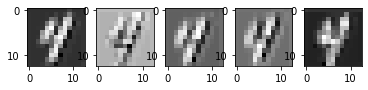

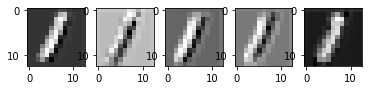

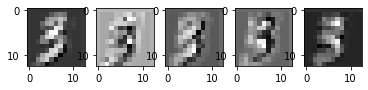

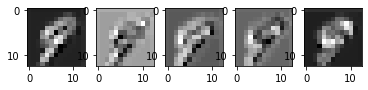

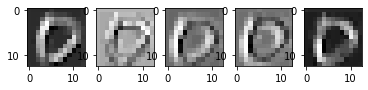

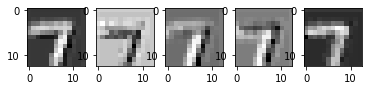

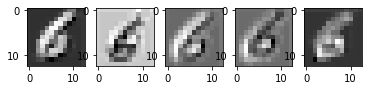

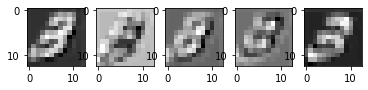

In [15]:
filter3 = nn.MaxPool2d(kernel_size=2, stride=2)
fm3 = filter3(fm2)
print(fm3.shape)  # (8, 5, 13, 13)

for n in range(batch_size):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        ax.imshow(fm3[n, i, :, :].detach().cpu().numpy(),  cmap="gray", interpolation="none")
    plt.show()

### Flattening Feature Maps & Unflattening vectors

In [16]:
# Make feature maps ready for Fully-connected layers!
# (8, 5, 13, 13) -> (8, 5*13*13)
out1 = torch.flatten(fm3, 1)
print(out1.shape)

hidden1 = nn.Linear(5*13*13, 64)
output1 = nn.Linear(64, 10)

out2 = hidden1(out1)
out3 = output1(out2)
print(out3.shape)

torch.Size([8, 845])
torch.Size([8, 10])


In [17]:
torch.flatten(fm3, 2).shape

torch.Size([8, 5, 169])

In [18]:
# Unflatten
torch.flatten(fm3, 1)

tensor([[-0.1315, -0.1412, -0.1412,  ...,  0.1504,  0.1504,  0.1573],
        [-0.1315, -0.1412, -0.1412,  ...,  0.1504,  0.1504,  0.1573],
        [-0.1315, -0.1412, -0.1412,  ...,  0.1504,  0.1504,  0.1573],
        ...,
        [-0.1315, -0.1412, -0.1412,  ...,  0.1504,  0.1504,  0.1573],
        [-0.1315, -0.1412, -0.1412,  ...,  0.1504,  0.1504,  0.1573],
        [-0.1315, -0.1412, -0.1412,  ...,  0.1504,  0.1504,  0.1573]],
       grad_fn=<ReshapeAliasBackward0>)

In [19]:
nn.Unflatten(1, (5, 13, 13))(torch.flatten(fm3, 1)).shape

torch.Size([8, 5, 13, 13])

In [20]:
filter4 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3,
                    stride=1, padding=1)
fm4 = filter4(fm3)
fm4.shape

torch.Size([8, 10, 13, 13])

## In-class Exercise 1: Make a pipeline for multiple convolution

torch.Size([8, 5, 15, 15])


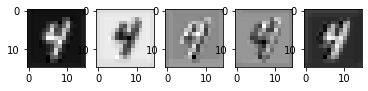

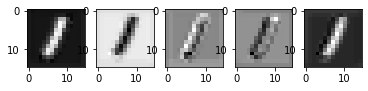

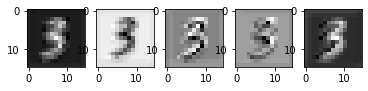

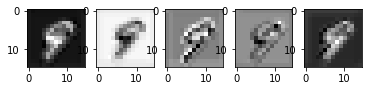

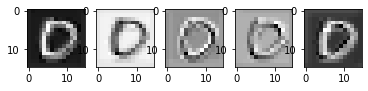

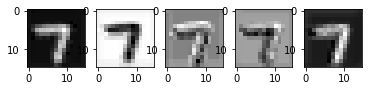

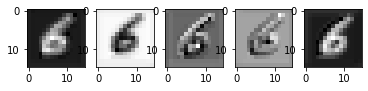

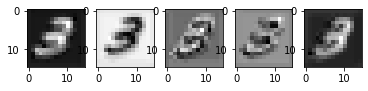

In [21]:
pipeline = nn.Sequential(
    # (8, 1, 28, 28) -> (8, 5, 28, 28)
    nn.Conv2d(in_channels=1,
              out_channels=5,
              kernel_size=3,
              stride=1, padding=1),
    # (8, 5, 28, 28) -> (8, 5, 14, 14)
    nn.AvgPool2d(kernel_size=2),
    # <== ADD 1 LINE FOR POOLING (kernel_size=?) #####################
    # (8, 5, 14, 14) -> (8, 5, 15, 15)
    nn.Conv2d(in_channels=5, out_channels=5, kernel_size=2,
              stride=1, padding=1))

out = pipeline(X)
print(out.shape)
for n in range(batch_size):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        ax.imshow(out[n, i, :, :].detach().cpu().numpy(),  cmap="gray", interpolation="none")
    plt.show()

In [22]:
filter3 = nn.Conv2d(in_channels=1,
             out_channels=5,
             kernel_size=3,
             stride=1, padding=1)
filter3(X).shape

torch.Size([8, 5, 28, 28])

## In-class Exercise 2: Make 1x2x2 feature map by applying at least 2 convolution and 2 pooling filters

torch.Size([8, 1, 28, 28])


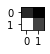

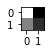

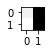

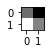

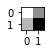

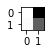

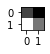

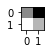

In [23]:
#
print(X.shape) #  (8, 1, 28, 28)

pipeline = nn.Sequential(
    # (8, 1, 28, 28) -> (8, 5, 28, 28)
    nn.Conv2d(in_channels=1,
              out_channels=5,
              kernel_size=3,
              stride=1,
              padding=1),
    # (8, 5, 28, 28) -> (8, 5, 7, 7)
    nn.AvgPool2d(kernel_size=4),
    # (8, 5, 7, 7) -> (8, 1, 8, 8)
    nn.Conv2d(in_channels=5,
              out_channels=1,
              kernel_size=2,
              stride=1, padding=1),
    nn.AvgPool2d(kernel_size=4))

out = pipeline(X)
for n in range(batch_size):
    ax = plt.subplot(batch_size, 1, i + 1)
    ax.imshow(out[n, 0, :, :].detach().cpu().numpy(),  cmap="gray", interpolation="none")
    plt.show()

## Convolutional Autoencoder (Demo)

In [24]:
class ConvAutoEncoder(nn.Module):
    def __init__(self,
                 hidden_dim: int = 16):
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1,
                                               out_channels=8,
                                               kernel_size=3,
                                               stride=1,
                                               padding=1), #-> (_, 8, 28, 28)
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=8,
                                               out_channels=4,
                                               kernel_size=3,
                                               stride=1,
                                               padding=1), #-> (_, 4, 28, 28)
                                     nn.MaxPool2d(kernel_size=2, stride=2)) #-> (_, 1, 28, 28)
        self.flatten = nn.Flatten(start_dim=1) #-> (-, 1*28*28)
        self.hidden1 = nn.Linear(1*28*28, hidden_dim)  # -> 16
        self.hidden2 = nn.Linear(hidden_dim, 1*28*28)  # -> 4*28*28
        self.unflatten = nn.Unflatten(1, (1, 28, 28))  # -> (1, 28, 28)
        self.decoder = nn.Sequential(nn.ConvTranspose2d(in_channels=1,
                                                        out_channels=4,
                                                        kernel_size=3,
                                                        stride=1,
                                                        padding=1),  #->(_, 4, 28, 28)
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(in_channels=4,  #->(_, 1, 28, 28)
                                                        out_channels=1,
                                                        kernel_size=3,
                                                        stride=1,
                                                        padding=1))
        
    def encode(self, x):
        out = self.encoder(x)
        out = self.flatten(out)
        out = self.hidden1(out)
        return out

    def decode(self, x):
        out = self.hidden2(x)
        out = self.unflatten(out)
        out = self.decoder(out)
        return out

    def forward(self, x):
        out = self.encode(x)
        out = self.decode(out)
        return out

In [25]:
def train(model: nn.Module,
              train_dataset: Dataset,
              valid_dataset: Dataset,
              config: Dict[str, Any],
              random_seed: int = 0):
  
    # Random Seeds ===============
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    # Random Seeds ===============

    # GPU configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = torch.device("tpu" if torch.cuda.is_available() else "cpu")

    dl_train = DataLoader(train_dataset,
                          batch_size=config["batch_size"])
    dl_valid = DataLoader(valid_dataset)
                  
    # Model, Optimzier, Loss function
    model = model.to(device)

    # Optimizer
    optimizer = config["optimizer_cls"](model.parameters(), lr=config["lr"])
    loss_fn = nn.MSELoss()

    # For each epoch
    eval_list = []
    t0 = time()
    best_val = None
    best_model = None
    for n in range(config["n_epochs"]):
        t1 = time()
        print("Epoch {}".format(n))
        # Training
        train_loss = 0.
        train_pred_list = []
        train_true_list = []
        model.train()  # Switch to the training mode

        # For each batch
        for batch in dl_train:
            optimizer.zero_grad()              # Initialize gradient information
            X, y = batch
            # X = X.view(X.size(0), -1).to(device) # (batch_size, 1, 28, 28) -> (batch_size, 768)
            X = X.to(device)  # Keep (batch_size, 1, 28, 28)
            out = model(X)                     # Call `forward()` function of the model
            loss = loss_fn(torch.flatten(out, 1), torch.flatten(X, 1)) # Calculate loss 
            loss.backward()                    # Backpropagate the loss value
            optimizer.step()                   # Update the parameters
            train_loss += loss.data.item() * config["batch_size"]

        train_loss /= (len(dl_train) * config["batch_size"])
        print("    Training loss: {:.4f}".format(train_loss))

        # Validation
        valid_loss = 0.
        valid_pred_list = []
        valid_true_list = []

        model.eval()  # Switch to the evaluation mode
        valid_emb_list = []
        valid_label_list = []
        for i, batch in enumerate(dl_valid):
            X, y = batch
            # X = X.view(X.size(0), -1).to(device) # (batch_size, 1, 28, 28) -> (batch_size, 768)
            X = X.to(device)  # Keep (batch_size, 1, 28, 28)
            out = model(X)
            loss = loss_fn(torch.flatten(out, 1),
                           torch.flatten(X, 1))
            valid_loss += loss.data.item()

        valid_loss /= len(dl_valid)
        print("  Validation loss: {:.4f}".format(valid_loss))

        # Model selection
        if best_val is None or valid_loss < best_val:
            best_model = copy.deepcopy(model)
            best_val = valid_loss

        # Orig/generated image pair
        x_pair = torch.cat([X[0].reshape(28, 28), torch.zeros(28, 1).to(device),
                            model(X[0].unsqueeze(0)).reshape(28, 28)], axis=1)
        plt.imshow(x_pair.detach().cpu().numpy(),
                  cmap="gray", interpolation="none")
        plt.show()

        t2 = time()
        print("     Elapsed time: {:.1f} [sec]".format(t2 - t1))

        # Store train/validation loss values
        eval_list.append([n, train_loss, valid_loss, t2 - t1])

    eval_df = pd.DataFrame(eval_list, columns=["epoch", "train_loss", "valid_loss", "time"])
    eval_df.set_index("epoch")

    print("Total time: {:.1f} [sec]".format(t2 - t0))

    # Return the best model and trainining/validation information
    return {"model": best_model,
            "best_val": best_val,
            "eval_df": eval_df}

Epoch 0
    Training loss: 0.4939
  Validation loss: 0.2851


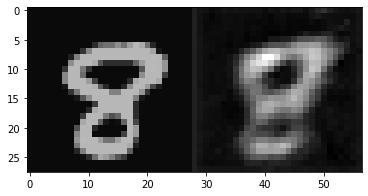

     Elapsed time: 28.9 [sec]
Epoch 1
    Training loss: 0.2601
  Validation loss: 0.2458


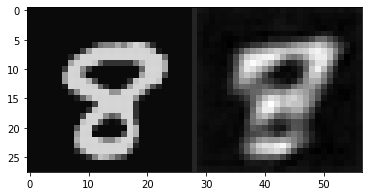

     Elapsed time: 28.6 [sec]
Epoch 2
    Training loss: 0.2374
  Validation loss: 0.2317


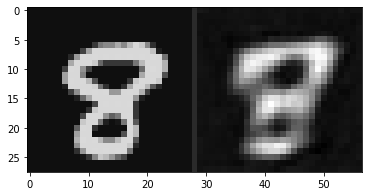

     Elapsed time: 28.7 [sec]
Epoch 3
    Training loss: 0.2258
  Validation loss: 0.2222


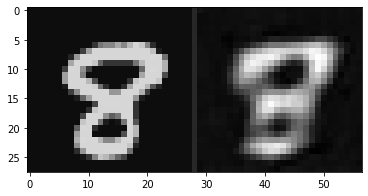

     Elapsed time: 28.7 [sec]
Epoch 4
    Training loss: 0.2173
  Validation loss: 0.2145


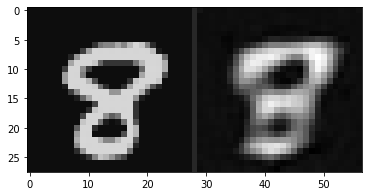

     Elapsed time: 28.5 [sec]
Epoch 5
    Training loss: 0.2100
  Validation loss: 0.2080


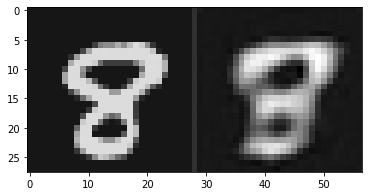

     Elapsed time: 28.6 [sec]
Epoch 6
    Training loss: 0.2039
  Validation loss: 0.2026


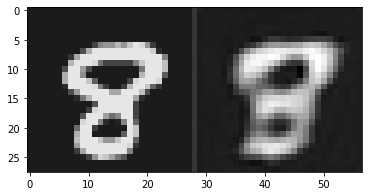

     Elapsed time: 28.3 [sec]
Epoch 7
    Training loss: 0.1991
  Validation loss: 0.1987


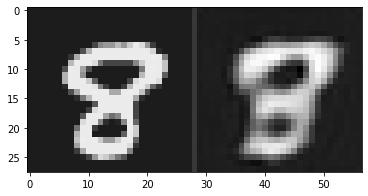

     Elapsed time: 28.3 [sec]
Epoch 8
    Training loss: 0.1957
  Validation loss: 0.1959


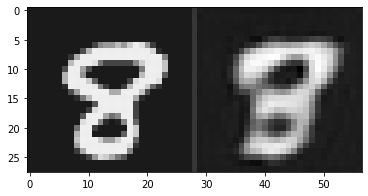

     Elapsed time: 28.2 [sec]
Epoch 9
    Training loss: 0.1933
  Validation loss: 0.1938


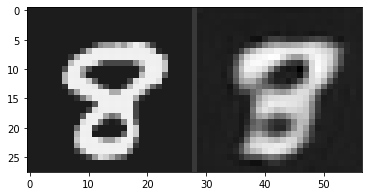

     Elapsed time: 28.2 [sec]
Total time: 284.9 [sec]


In [26]:
# lr = {0.01, 0.001, 0.0001}
config = {"optimizer_cls": optim.Adam,
          "lr": 0.0001,
          "batch_size": 16,
          "n_epochs": 10}
model = ConvAutoEncoder()      # lr = 0.0001
output = train(model, train_dataset, valid_dataset, config)